# **Installing Necessary Dependencies**

In [ ]:
!pip install -q pycountry

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 59.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# **Importing Necessary Packages**

In [ ]:
import pycountry                                        #to analyze the countries data
import numpy as np                                      #package for handling arrays
import pandas as pd                                     #package for data analysis
import seaborn as sns                                   #package for data visualization
import matplotlib.pyplot as plt                         #package for data visualization and charts manipulations
from sklearn.preprocessing import MinMaxScaler          #Importing MinMaxScaker for data normalization
from sklearn.cluster import KMeans                      #Importing Kmean from sklearn
from scipy.optimize import curve_fit                    #Importing curve_fit from scipy
import statsmodels.api as sm                            #Package for implementaion of statistics
scaler=MinMaxScaler()                                   #Creating object of MinMaxScaler

# **Reading the Data**

In [ ]:
def load_data(file):
  """
  this function receives data file remove metadata and splits data into two
  chunks of year_data and country_data
  """

  df = pd.read_csv(file, skiprows=4)
  
  # Drop unnecessary columns
  df = df.iloc[:, :-1]
  
  year_data = df.copy()
  
  # Create a dataset with countries as columns
  country_data = df.set_index(["Country Name", "Indicator Name"])
  country_data.drop(["Country Code", "Indicator Code"], axis=1, inplace=True)
  
  # Transpose the countries dataframe
  country_data = country_data.T
  
  # Return the years and countries dataframes
  return year_data, country_data

In [ ]:
data_frame, countries = load_data("climate_indicators.csv")

# **Extracting Some Necessary Data of Indicators against Countries**

In [ ]:
def extracted_data(data, indicators_list):
    # Filter the dataset for the required indicators
    extracted_data = data[data["Indicator Name"].isin(indicators_list)]
    # Extracting data for only countries we are interested in
    country_list = [country.name for country in list(pycountry.countries)]
    extracted_data = extracted_data[extracted_data["Country Name"].isin(country_list)]
    return extracted_data

# **Indicators**

In [ ]:

indicators_list = [
    'Access to electricity (% of population)',
    'Agricultural land (% of land area)',
    'Forest area (% of land area)',
    'CO2 emissions (metric tons per capita)',
    'Total greenhouse gas emissions (kt of CO2 equivalent)',
    'Renewable electricity output (% of total electricity output)',
    'Renewable energy consumption (% of total final energy consumption)',
    'Electricity production from coal sources (% of total)',
    'Electricity production from oil sources (% of total)',   
]

In [ ]:
data = extracted_data(data_frame, indicators_list)

In [ ]:
data = data.fillna(method='ffill').fillna(method='bfill')
pivot_data = data.pivot_table(index='Country Name', columns='Indicator Name', values='2020')

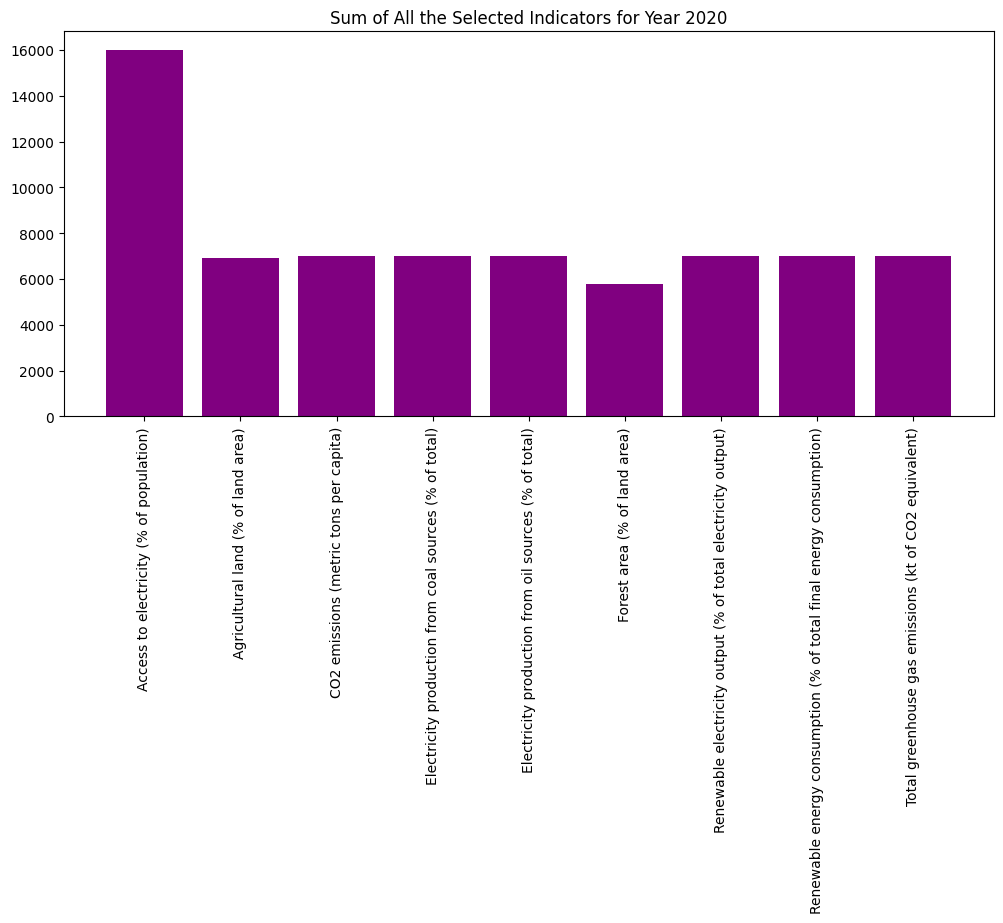

In [ ]:
plt.figure(figsize=(12,5))
plt.bar(x=pivot_data.sum().index,height=pivot_data.sum().values,color='purple')
plt.xticks(rotation=90)
plt.title('Sum of All the Selected Indicators for Year 2020')
plt.show()

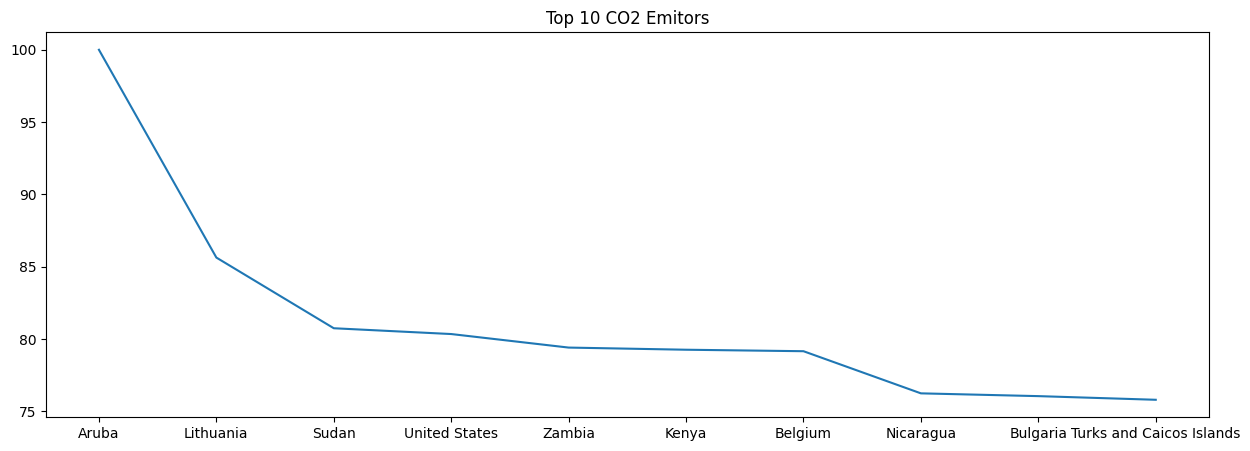

In [ ]:
co_index=pivot_data['CO2 emissions (metric tons per capita)'].sort_values(ascending=False)[0:10]
plt.figure(figsize=(15,5))
plt.plot(co_index.index,co_index.values)
plt.title('Top 10 CO2 Emitors')
plt.show()

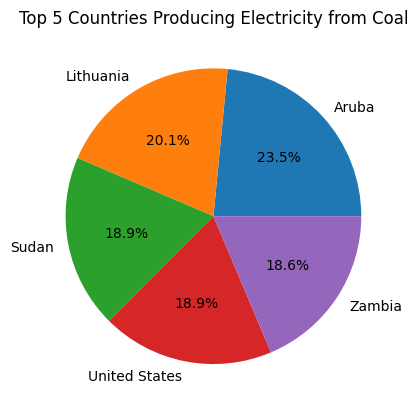

In [ ]:
electric_coal=pivot_data['Electricity production from coal sources (% of total)'].sort_values(ascending=False)[0:5]
plt.pie(electric_coal.values,labels=electric_coal.index,autopct='%.1f%%')
plt.title("Top 5 Countries Producing Electricity from Coal")
plt.show()

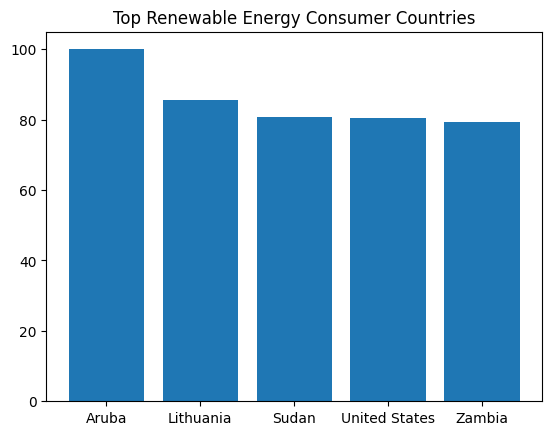

In [ ]:
re_usage=pivot_data['Renewable energy consumption (% of total final energy consumption)'].sort_values(ascending=False)[0:5]
plt.bar(x=re_usage.index,height=re_usage.values)
plt.title("Top Renewable Energy Consumer Countries")
plt.show()

# **Clustering**

In [ ]:
# data Normalization
norm_data, min_value, max_value = scaler.fit_transform(pivot_data.values),np.min(pivot_data.values),np.max(pivot_data.values)

# number of clusters
cluster_count = 4

# Applying KMeans
kmeans = KMeans(n_clusters=cluster_count, random_state=0)
cluster_labels = kmeans.fit_predict(norm_data)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# Add the cluster labels to the dataset
pivot_data["Cluster"] = cluster_labels
pivot_data.groupby("Cluster").mean()
labels = indicators_list

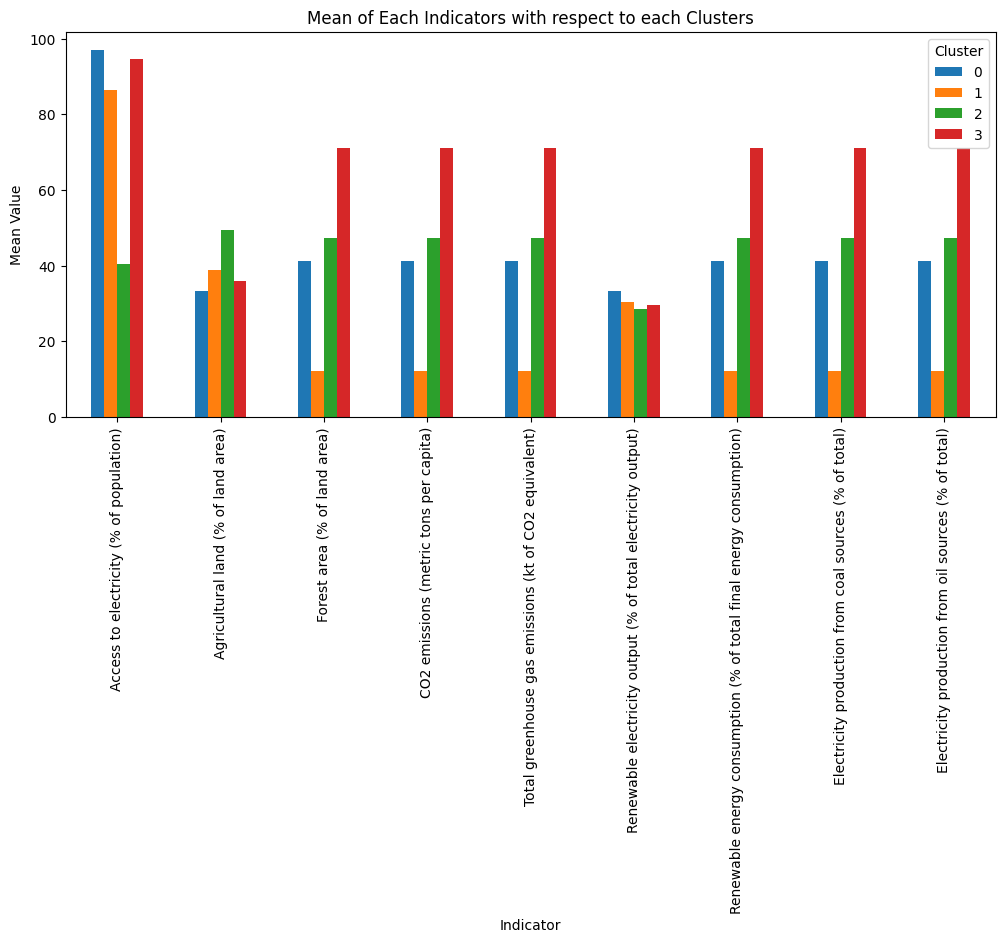

In [ ]:
temp = pivot_data.groupby("Cluster").mean().T
temp.index = labels
temp.plot(kind="bar", figsize=(12, 5))
plt.title("Mean of Each Indicators with respect to each Clusters")
plt.ylabel("Mean Value")
plt.xlabel("Indicator")
plt.show()

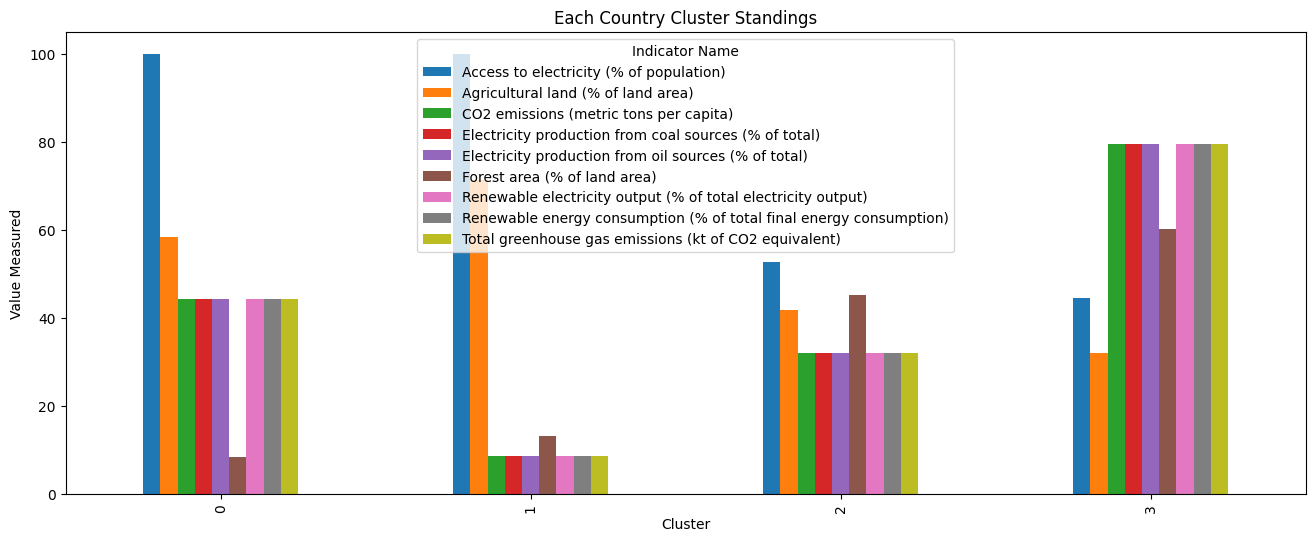

In [ ]:
# Selecting one country from each cluster
pivot_data.groupby("Cluster").last()

# Comparing values for each country
pivot_data.groupby("Cluster").last().plot(kind="bar", figsize=(16, 6))
plt.title("Each Country Cluster Standings")
plt.ylabel("Value Measured")
plt.show()

In [ ]:
def ln_function(x, a, b):
    return a*x + b

In [ ]:
def fit_model(x_vals, y_vals, linear_func, sigma=[1.0, 1.0]):
    popt, pcov = curve_fit(linear_func, x_vals, y_vals)
    x_pred = np.arange(2020, 2040)
    y_pred = ln_function(x_pred, *popt)



    # Estimate confidence intervals for predicted values
    model = sm.OLS(y_vals, sm.add_constant(x_vals))
    fitted_model = model.fit()
    prediction = fitted_model.get_prediction(sm.add_constant(x_pred))
    mean_values = prediction.predicted_mean
    lower = prediction.conf_int()[:, 0]
    upper = prediction.conf_int()[:, 1]

    #lower, upper = err_ranges(x_pred, linear_func, popt, sigma)
    
    print(f"Predictd data values are givne below")
    print(y_pred)
    
    # plot the model function and the confidence intervals for the predictions
    plt.figure(figsize=(12, 5))
    plt.plot(x_vals, y_vals, '*', label='Given Data',color='green')
    plt.plot(x_pred, y_pred, 'r-', label='linearly Fittited Line',color='black')
    plt.fill_between(x_pred, lower, upper, color='black', alpha=0.2, label='CI')
    plt.legend(loc='best')
    plt.title("Urban population Prediction")
    plt.xlabel('Year')
    plt.ylabel('Total Population')
    plt.show()

Predictd data values are givne below
[4.10428710e+09 4.16042268e+09 4.21655825e+09 4.27269382e+09
 4.32882940e+09 4.38496497e+09 4.44110055e+09 4.49723612e+09
 4.55337169e+09 4.60950727e+09 4.66564284e+09 4.72177841e+09
 4.77791399e+09 4.83404956e+09 4.89018514e+09 4.94632071e+09
 5.00245628e+09 5.05859186e+09 5.11472743e+09 5.17086300e+09]


<ipython-input-104-d4536f1a0f18>:24: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  plt.plot(x_pred, y_pred, 'r-', label='linearly Fittited Line',color='black')


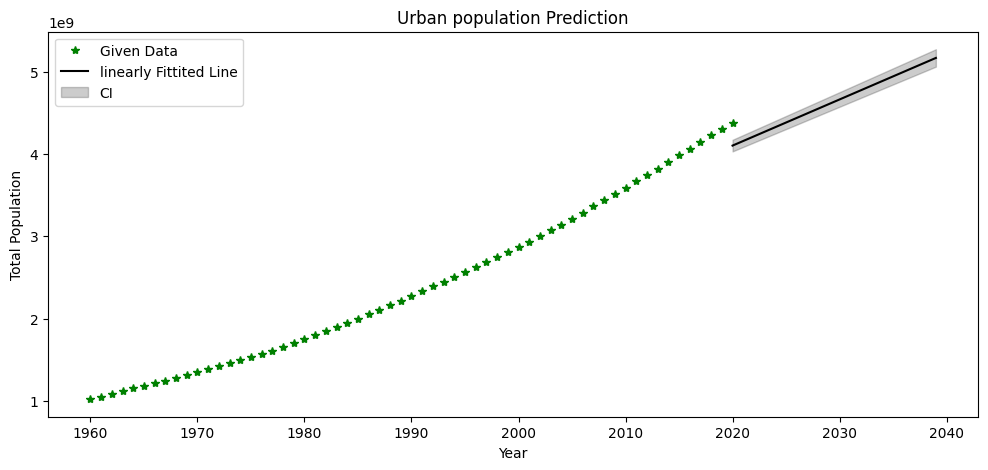

In [ ]:
# extract the data we want to fit the model to
data_points = countries[("World", "Urban population")]

X_values = data_points.index.astype("int")
y_values = data_points.values.astype("float64")

fit_model(X_values, y_values, ln_function)